# TP Mesure d'impédances

#### Quelques éléments de syntaxe Python (au cas où)

Vous trouverez ci-dessous quelques éléments de syntaxe Python qui pourraient *éventuellement* vous être utiles.

Considérations générales :
  * la valeur $\pi$ peut être obtenue à l'aide de la commande `np.pi` ;
  * le nombre imaginaire $i$ tel que $i^2 = -1$ est noté `1j` en Python ;
  * les indices démarrent à 0 en Python ;
  * l'accès au contenu d'un dictionnaire `mydict` pour l'entrée `key` s'effectue par la commande `mydict[key]` ;
  * les commentaires sont précédés de `#` (sur une ligne) ou encadrés par `"""` (sur plusieurs lignes) ;
  * la syntaxe d'une boucle `for` (élémentaire) est la suivante :
      ```python
      for element in iterable:
          # do something with element
      ```
  * un exemple de chaîne de caractères dynamique est `f"La valeur de a + b est {var_a + var_b}"` où `var_a` et `var_b` sont deux variables (le "f" en tête de chaîne indique d'évaluer les expressions entre accolades) ;
  * l'indentation indique les blocs de code (à la manière des `{...}` en C) ;
  * les puissances s'exprime par `**` (et non `^`) : `2**3 = 8` ;

Les fonctions mathématiques ou élémentaires dont vous pourriez avoir besoin sont disponibles en utilisant le préfixe `np.` :
  * `np.abs` (valeur absolue) ;
  * `np.angle` (argument de nombres complexes, en radians)
  * `np.mean` (moyenne) ;
  * `np.log10` (logarithme décimal) ;
  * `np.linspace` (construction d'un vecteur de points équirépartis) ;
  * etc.

Manipulation de tableaux :
  * le dernier élément d'un tableau peut être obtenu avec l'indice -1, l'avant-dernier avec l'indice -2, etc. ;
  * la sélection des `n` premiers éléments d'un tableau `arr` s'effectue avec la commande `arr[:n]` ;
  * la sélection des `n` derniers éléments d'un tableau `arr` s'effectue avec la commande `arr[-n:]` ;
  * la sélection des éléments `n_start` à `n_stop` (inclus) dans un tableau `arr` s'effectue avec la commande `arr[n_start:n_stop + 1]`.
  
**Pour obtenir de l'aide sur une fonction `func`, utilisez les commandes `help(func)` ou `func?` dans une cellule de code.** Ceci est valable même pour les fonctions personnalisées mises à votre disposition, pour lesquelles un effort de documentation a également fait.

## I/ Préparation des logiciels employés

### I-1/ Configuration du logiciel NanoVNA-saver

#### Connection du NanoVNA au logiciel

`Serial port control` :
  * `Rescan`
  * `Connect to device`
  
#### Configuration de l'affichage

`Display setup...` :

Configurer les graphes affichés selon le schéma **(TODO: à mettre à jour pour coller au texte de Corinne)**

|`Displayed charts`| | |
|:---            | :---: | :---: |
|S11 Smith Chart | None  | None  |
|None            | None  | None  |

puis clore la fenêtre.

À l'issue de cette étape, la fenêtre principale du logiciel NanoVNA-saver devrait ressembler à
![illustration_ecran_principal_nanovnasaver](illustrations_notebook/fenetre_principale_nanovnasaver.png)

### I-2/ Préparation de Python et des éléments globaux

#### Chargement des bibliothèques nécessaires

In [1]:
# Permet l'affichage de graphes dynamiques (=> zoom possible)
%matplotlib notebook

# Bibliothèques générales
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Bibliothèque(s) personnalisée(s)
# -> Fonctions utiles pour le TP
from impedance_measurement_library import (
    load_nanovna_s1p_file,                 # charger un fichier de données S11 (NanoVNA)
    create_z_vs_f_double_figure,           # préparer une nouvelle figure à 2 panneaux
    add_z_vs_f_lineplot_two_panels,        # ajouter une ligne de données à une figure à deux panneaux
    add_ideal_c_vs_f_lineplot_two_panels,  # ajouter le modèle d'un C idéal à un graphe
    add_ideal_l_vs_f_lineplot_two_panels,  # ajouter le modèle d'une L idéal à un graphe
    add_ideal_r_vs_f_lineplot_two_panels,  # ajouter le modèle d'une R idéal à un graphe
    update_panel_cosmeticks,               # appliquer d'ultime retouches cosmétiques
    add_figure_title,                      # ajout d'un titre général à une figure
    save_figure,                           # exporter une figure en PDF ou en PNG
)
# -> Clefs de dictionnaire pré-définies permettant notamment
#    d'utiliser les styles personnalisés pré-définis.
from impedance_measurement_stylesheet import (
    MEAS_ZS, MEAS_ZP, MEAS_ZS_AND_ZP,          # mesures pour le de-embedding
    MODEL_ZS, MODEL_ZP,                        # modèles pour le de-embedding
    #
    # De gauche à droite :
    # mesures avant de-embedding, valeurs après de-embeeding, vérité terrain
    MEAS_C1_LONG, DUT_C1_LONG, GT_C1_LONG,     # C1 aux pattes longues
    MEAS_C2_LONG, DUT_C2_LONG, GT_C2_LONG,     # C2 aux pattes longues
    MEAS_C1_SHORT, DUT_C1_SHORT, GT_C1_SHORT,  # C1 aux pattes courtes
    MEAS_C2_SHORT, DUT_C2_SHORT, GT_C2_SHORT,  # C2 aux pattes courtes
    #
    # Éventuels composants additionnels
    GT_C3, GT_C4, GT_R1, GT_R2, GT_L1, GT_L2, GT_P1
)

#### Enregistrement des figures

Les figures sauvées par la fonction personnalisée `save_fig` sont enregistrées par défaut dans le répertoire `./figures`.

#### Définition des conteneurs de données
Plusieurs dictionnaires Python sont initialisés et permettront par la suite de stocker les différents vecteurs de données utiles avec une syntaxe uniforme dans le reste du code.

Par exemple, pour accéder aux données S11 (préalablement chargées) correspondant à l'impédance $Z_s$, il suffira d'utiliser l'appel `donnees_s11[ZS]`. De même, pour accéder aux données d'impédance (préalablement calculées) pour le condensateur C1 et aux pattes longues, l'appel à employer sera :
  * `donnees_z[MEAS_C1_LONG]` pour les données de mesures brutes (avant de-embedding) ;
  * `donnees_z[DUT_C1_LONG]` pour les données obtenues après de-embedding ;
  * `donnees_z[GT_C1_LONG]` pour les données de vérité terrain.

_**Ne pas modifier le contenu de la cellule ci-dessous.**_

In [2]:
# Dictionnaires Python pour stocker les vecteurs de données utiles.
donnees_s11 = {}  # paramètres S11
frequences = {}   # fréquences utilisées pour relever les paramètres S11 
donnees_z = {}    # impédances (complexes) calculées à partir des paramètres S11

#### Définition de l'emplacement des données à traiter
_À modifier **si nécessaire** pour refléter le répertoire que vous utilisez._

In [3]:
# Répertoire où se trouve(ro)nt les fichiers de données *.s1p
#
data_directory = Path("./data")

### I-3/ Préparation des mesures
Dans le cas présent à l'aide du logiciel NanoVNA-saver.

#### Définition du stimulus de mesure

`Sweep control` :
  * `Start` : "100kHz" (sans les guillemets)
  * `Stop` : "1GHz" (sans les guillemets)
  * `Segments` : 10
 
`Sweep settings` :
  * `Settings` : Average sweep
  * `Logarithmic sweep` : à cocher ? _**(TODO: à vérifier avec Bernard avant le TP)**_
  * `Numbers of measurements to average` : 5
  * `Number to discard` : 2
  * Clore la fenêtre.

#### Calibration du VNA en sortie de châssis

Dans le cadre de ce TP, nous commencerons par employer un fichier de calibration préalablement enregistré, afin de simplifier la prise en main des mesures. La procédure est la suivante : `Calibration...` -> `Load calibration` -> aller chercher le fichier de calibration se trouvant dans le répertoire `./calibration_nanovna` (du dossier courant) :

`ph106-chassis_output-100e3Hz_1e9Hz-log-5S2D_avg-10seg.cal`

_**TODO : demander à Bernard d'enregistrer un tel fichier.**_

###  I-4/ Calcul de l'impédance Z à partir des valeur du paramètre S11

#### Rappels théoriques

Le coefficient de réflexion $\Gamma$ sur une impédance de charge peut être exprimé par l'équation
$$ \Gamma = \frac{Z - Z_0}{Z + Z_0}, $$
où $Z$ est l'impédance (complexe) de charge et $Z_0$ l'impédance caractéristique.


#### Routine de calcul
En identifiant le paramètre $S_{11}$ au coefficient de réflexion $\Gamma$ précédent, complétez la fonction ci-dessous afin qu'elle renvoie l'impédance de charge $Z$ vue en shunt par le VNA dans son plan de mesure (c'est-à-dire en sortie du châssis de l'appareil pour le moment).

In [4]:
def compute_shunt_impedance(s11, z0=50.0):
    """
    Computes the shunt impedance *z_shunt* based on the value(s) *s11*
    of the S11 parameter and knowing the characteristic impedance *z0*
    (default value for *z0* is 50 ohms).
    
    Parameters
    ----------
    s11 : scalar or nd-array.
        The (complex) value(s) of the S11 parameter.
    z0 : scalar or nd-array, optional.
        The characteristic impedance Z0. The default value is 50 ohms.

    Returns
    -------
    z_shunt : scalar or nd-array
        The (complex) impedance seen in shunt in the same plan as S11.
    """
    #z_shunt = ...  # À COMPLÉTER
    z_shunt = z0 * (1 + s11)/(1 - s11)

    return z_shunt

## II/ De-embedding manuel

### II-1/ Détermination expérimentale de l'impédance Zs

#### Mesure du S11 avec l'impédance Zs

Afin d'estimer l'impédance en série $Z_s$, effectuez un relevé expérimental en court-circuit au bout de la fixture (par exemple entre les broches B1 et C1 de ladite fixture).

#### Calcul des valeurs expérimentales (brutes) de l'impédance Zs

Chargez le fichier `*.s1p` obtenu et calculez les valeurs d'impédance associées.

NB : la clef de dictionnaire associée est `MEAS_ZS`.

In [5]:
filename = "<nom_du_fichier_de_donnees_s11_associe_a_zs.s1p"  # À MODIFIER SELON LE NOM DE VOTRE FICHIER
filename = "prototype-meas_zs.s1p"  # DEBUG

# Chargement des données de mesures (fréquences et valeurs de S11) contenues dans le fichier `filename`.
frequences[MEAS_ZS], donnees_s11[MEAS_ZS] = load_nanovna_s1p_file(data_directory / filename)

# Calcul des valeurs d'impédance Zs à partir des celles de S11
donnees_z[MEAS_ZS] = compute_shunt_impedance(donnees_s11[MEAS_ZS])

### II-2/ Détermination expérimentale de l'impédance Zp

#### Mesure du S11 avec l'impédance Zs + Zp

Afin d'estimer l'impédance totale $Z_s + Z_p$, effectuez un relevé expérimental de $S_{11}$ en circuit ouvert au bout de la fixture.

#### Calcul des valeurs expérimentales (brutes) de l'impédance Zs + Zp

Chargez le fichier `*.s1p` obtenu et calculez les valeurs d'impédance associées.

NB : la clef de dictionnaire associée est `MEAS_ZS_AND_ZP`.

In [6]:
filename = "<nom_du_fichier_de_donnees_s11_associe_a_zs_et_zp.s1p"  # À MODIFIER SELON LE NOM DE VOTRE FICHIER
filename = "prototype-meas_zs_and_zp.s1p"  # DEBUG

# Chargement des données de mesures (fréquences et valeurs de S11) contenues dans le fichier `filename`.
frequences[MEAS_ZS_AND_ZP], donnees_s11[MEAS_ZS_AND_ZP] = load_nanovna_s1p_file(data_directory / filename)

# Calcul des valeurs d'impédance Zs à partir des celles de S11
donnees_z[MEAS_ZS_AND_ZP] = compute_shunt_impedance(donnees_s11[MEAS_ZS_AND_ZP])

#### Calcul des valeurs expérimentales (brutes) de l'impédance Zs

Déterminez l'impédance $Z_s$ à partir des relevés expérimentaux précédents. Vous stockerez le résultat dans `donnees_z[MEAS_ZP]`.

In [7]:
#donnees_z[MEAS_ZP] = ...  # À MODIFIER
donnees_z[MEAS_ZP] = donnees_z[MEAS_ZS_AND_ZP] - donnees_z[MEAS_ZS]  # DEBUG

_**Ne pas modifier le contenu de la cellule ci-dessous.**_ (Cette dernière sert à garantir une structures de données pour les fréquences similaire à celles des autres données d'impédance afin de simplifier les manipulations ultérieures, comme le tracé de graphes).

In [8]:
frequences[MEAS_ZP] = np.copy(frequences[MEAS_ZS])

### Tracé des impédances Zs et Zp

<IPython.core.display.Javascript object>


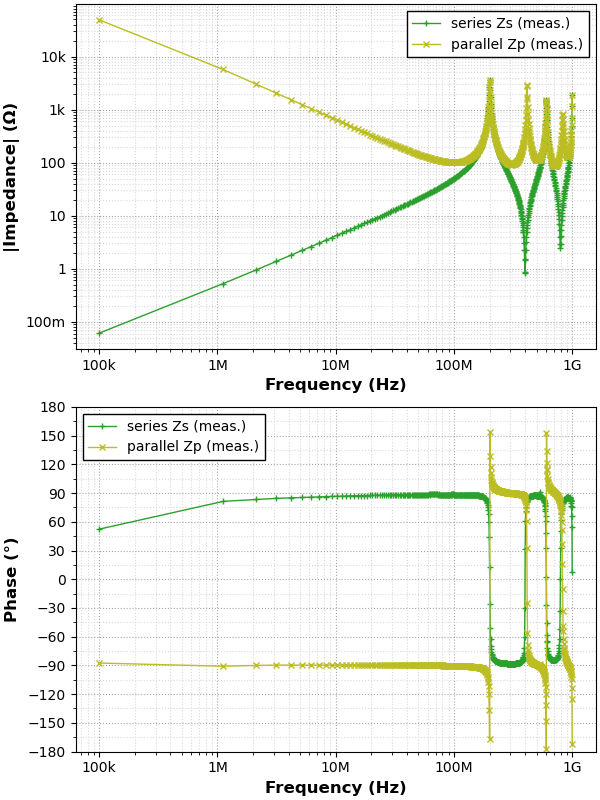

array([<AxesSubplot:xlabel='Frequency (Hz)', ylabel='|Impedance| (Ω)'>,
       <AxesSubplot:xlabel='Frequency (Hz)', ylabel='Phase (°)'>],
      dtype=object)

In [9]:
# Mise en place d'une nouvelle figure
fig0, axs0 = create_z_vs_f_double_figure("fig0-zs_and_zp_measurement_plot")
fig, axs = fig0, axs0  # simplifie les copier-coller

# Tracé des mesures expérimentales de l'impédance Zs
f_values = frequences[MEAS_ZS]
z_values = donnees_z[MEAS_ZS]
add_z_vs_f_lineplot_two_panels(f_values, z_values,
                               axs=axs, key=MEAS_ZS)

# Tracé des mesures expérimentales de l'impédance Zp
f_values = frequences[MEAS_ZP]
z_values = donnees_z[MEAS_ZP]
add_z_vs_f_lineplot_two_panels(f_values, z_values,
                               axs=axs, key=MEAS_ZP)

In [10]:
save_figure(fig=fig0, fmt="png")

### Construction d'un modèle analytique simple pour Zs

In [11]:
# Copie des données manipulées, par précaution
f_vals = np.copy(frequences[MEAS_ZS])
z_vals = np.copy(donnees_z[MEAS_ZS])

# À COMPLÉTER
# Estimation d'un modèle d'impédance simple pour le dipôle Zs
#estimated_inductance = ...
estimated_inductance = np.mean(np.abs(z_vals[1:60])/(2*np.pi*f_vals[1:60]))  # DEBUG

# Retour utilisateur (en nH)
print(f"\nZs model:\n=> L_est = {estimated_inductance:0.4g} H.")


Zs model:
=> L_est = 6.648e-08 H.


In [12]:
# Ne pas modifier la ligne suivante
frequences[MODEL_ZS] = np.copy(frequences[MEAS_ZS])

# À COMPLÉTER
#ls_model = ...  # in H
#donnees_z[MODEL_ZS] = ...
#
# DEBUG
ls_model = 66.5e-9  # DEBUG
donnees_z[MODEL_ZS] = 1j * ls_model * 2*np.pi*frequences[MODEL_ZS]  # DEBUG

### Construction d'un modèle analytique simple pour Zp

In [13]:
# Copie des données manipulées, par précaution
f_vals = np.copy(frequences[MEAS_ZP])
z_vals = np.copy(donnees_z[MEAS_ZP])

# À COMPLÉTER
# Estimation d'un modèle d'impédance simple pour le dipôle Zp
#estimated_capacitance = ...
estimated_capacitance = np.mean(1 / (np.abs(z_vals[1:60]) * 2*np.pi*f_vals[1:60]))  # DEBUG

# Retour utilisateur (en pF)
print(f"\nZp model:\n=> C_est = {estimated_capacitance:0.4g} F.")


Zp model:
=> C_est = 2.336e-11 F.


In [14]:
# Ne pas modifier la ligne suivante
frequences[MODEL_ZP] = np.copy(frequences[MEAS_ZP])

# À COMPLÉTER
#cp_model = ...  # in F
#donnees_z[MODEL_ZS] = ...
#
# DEBUG
cp_model = 23.4e-12  # DEBUG
donnees_z[MODEL_ZP] = 1 / (1j * cp_model * 2*np.pi*frequences[MODEL_ZP])  # DEBUG

### Tracé de Zp et Zs en superposant leurs modèles analytiques

<IPython.core.display.Javascript object>


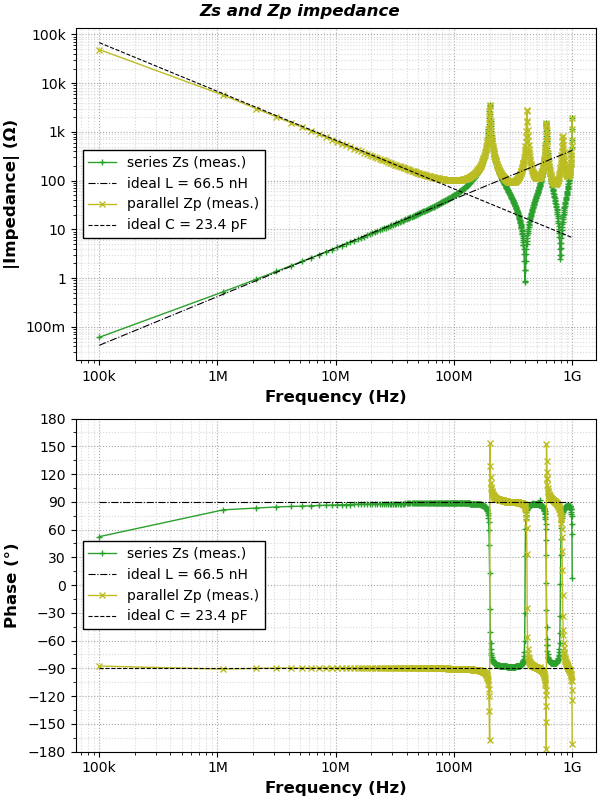

<IPython.core.display.Javascript object>


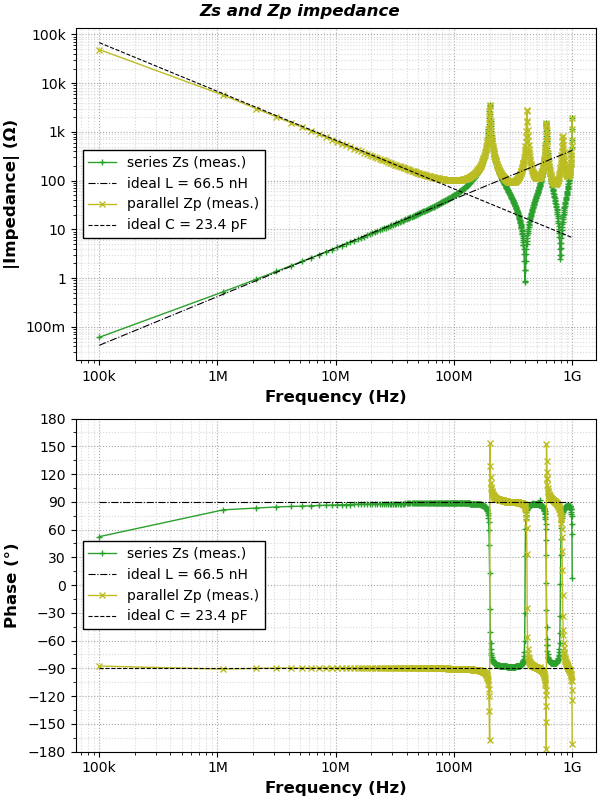

In [15]:
# Mise en place d'une nouvelle figure
fig1, axs1 = create_z_vs_f_double_figure("fig1-zs_and_zp_plot_with_analytical_models")
fig, axs = fig1, axs1  # simplifie les copier-coller

# Élément Zs en série
#
# Tracé des mesures expérimentales
f_values = frequences[MEAS_ZS]
z_values = donnees_z[MEAS_ZS]
add_z_vs_f_lineplot_two_panels(f_values, z_values,
                               axs=axs, key=MEAS_ZS)
# Ajout de la bobine idéale utilisée comme modèle
add_ideal_l_vs_f_lineplot_two_panels(f_values, ls_model,
                                     axs=axs, color="black")

# Élément Zp en parallèle
#
# Tracé des mesures expérimentales
f_values = frequences[MEAS_ZP]
z_values = donnees_z[MEAS_ZP]
add_z_vs_f_lineplot_two_panels(f_values, z_values,
                               axs=axs, key=MEAS_ZP)
# Ajout du condensateur idéal utilisé comme modèle
add_ideal_c_vs_f_lineplot_two_panels(f_values, cp_model,
                                     axs=axs, color="black")

# Améliorations cosmétiques diverses
add_figure_title("Zs and Zp impedance", fig=fig)

In [16]:
save_figure(fig=fig1, fmt="png")

### ??-?/ Détermination expérimentale de l'impédance de C1

#### Mesure du S11 avec le condensateur C1

Effectuez le relevé expérimental du $S_{11}$ du condensateur C1 (dans sa version aux pattes longues) en connectant ce dernier entre les mêmes broches de la fixture que celles employée pour établir le modèle de de-embedding.

#### Calcul des valeurs expérimentales (brutes) de l'impédance de C1

Chargez le fichier `*.s1p` obtenu et calculez les valeurs d'impédance associées.

NB : la clef de dictionnaire associée est `MEAS_C1_LONG`.

In [17]:
filename = "<nom_du_fichier_de_donnees_s11_associe_a_meas_c1_long.s1p"  # À MODIFIER SELON LE NOM DE VOTRE FICHIER
filename = "prototype-meas_c1_long.s1p"  # DEBUG

# Chargement des données de mesures (fréquences et valeurs de S11) contenues dans le fichier `filename`.
frequences[MEAS_C1_LONG], donnees_s11[MEAS_C1_LONG] = load_nanovna_s1p_file(data_directory / filename)

# Calcul des valeurs d'impédance de C1 (aux pattes longues) à partir des celles de S11
donnees_z[MEAS_C1_LONG] = compute_shunt_impedance(donnees_s11[MEAS_C1_LONG])

#### ??-?.c/ Fonction réalisant le de-embedding (manuel) de l'impédance mesurée

Complétez la fonction ci-dessous afin qu'elle renvoie l'impédance estimée $Z_{\mathrm{DUT}}$ du dispositif sous test après l'étape de de-embedding reposant sur le modèle analytique établi précédemment.

In [18]:
def apply_manual_deembedding(z_raw, zs_model, zp_model):
    """
    Manually de-embed measured impedance data *z_raw* using a
    simple two lumped element-model, where the device under
    test is in parallel with an ideal device with an _impedance_
    *zp_model*, which is then in series with another ideal
    device with an _impedance_ *zs_model*.
    
    Parameters
    ----------
    z_dut : scalar or nd-array
        The raw (complex) impedance measured at the VNA calibration plan.
    zs_model : scalar or nd-array
        The (complex) impedance of the model element Zs in series with
        the DUT and the model element Zp.
    zp_model : scalar or nd-array
        The (complex) impedance of the model element Zp in parallel with
        the DUT and in series with the model element Zs.

    Returns
    -------
    z_dut : scalar or nd-array
        The de-embedded (complex) impedance of the device under test.
    """
    #z_dut = ...  # À COMPLÉTER
    z_dut = zp_model * (z_raw - zs_model)/(zs_model + zp_model - z_raw)
    
    return z_dut

#### Calcul des valeurs de l'impédance de C1 après de-embedding

In [19]:
# Rappel des différents vecteurs pertinents déjà calculés
z_raw = donnees_z[MEAS_C1_LONG]
zs_model = donnees_z[MODEL_ZS]
zp_model = donnees_z[MODEL_ZP]

# Application du modèle analytique de Zs et Zp pour procéder au de-embedding
donnees_z[DUT_C1_LONG] = apply_manual_deembedding(z_raw, zs_model, zp_model)

# Ne pas modifier la ligne suivante
frequences[DUT_C1_LONG] = np.copy(frequences[MEAS_C1_LONG])

#### Tracé de l'impédance de C1 avant et après de-embedding

<IPython.core.display.Javascript object>


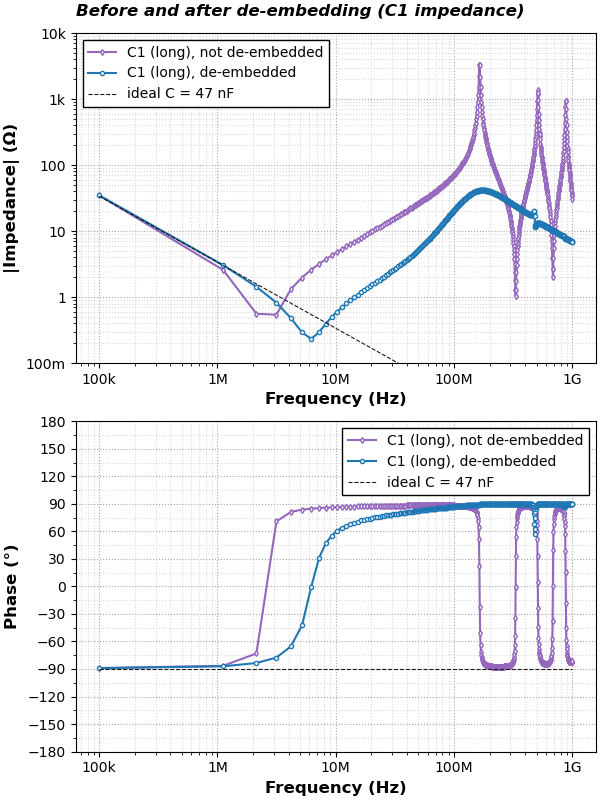

(0.1, 10000.0)

In [20]:
# Mise en place d'une nouvelle figure
fig2, axs2 = create_z_vs_f_double_figure("fig2-c1_long_impedance_before_and_after_deembedding_plot")
fig, axs = fig2, axs2  # simplifie les copier-coller

# Tracé de l'impédance de C1 avant de-embedding
f_values = frequences[MEAS_C1_LONG]
z_values = donnees_z[MEAS_C1_LONG]
add_z_vs_f_lineplot_two_panels(f_values, z_values,
                               axs=axs, key=MEAS_C1_LONG)

# Tracé de l'impédance de C1 après de-embedding
f_values = frequences[DUT_C1_LONG]
z_values = donnees_z[DUT_C1_LONG]
add_z_vs_f_lineplot_two_panels(f_values, z_values,
                               axs=axs, key=DUT_C1_LONG)

# Ajout de l'impédance du condensateur idéal attendue
c_ideal = 47e-9  # in F
add_ideal_c_vs_f_lineplot_two_panels(f_values, c_ideal, axs=axs)

# Améliorations cosmétiques diverses
add_figure_title("Before and after de-embedding (C1 impedance)", fig=fig)
axs[0].set_ylim(0.1, 10e3)  # autrement perte d'espace en raison de la trace "ideal C"

In [21]:
save_figure(fig=fig2, fmt="png")

### ??-?/ Calibration du VNA jusqu'en bout de fixture

Afin d'évaluer la qualité du de-embedding manuel précédent, nous allons procéder à la calibration du plan de mesure du VNA jusqu'au pied du dispositif sous test (c'est-à-dire jusqu'aux broches de la fixture utilisées pour mesurer C1 jusqu'à présent).

#### Procédure de calibration Short-Open-Load

Nous emploierons une procédure classique de calibration "1-port" (suffisante pour des mesures de S11), de type Short-Open-Load (SOL), parfois également nommée Short-Open-Matched. Cette méthode repose sur la combinaison d'une mesure en court-circuit, d'une mesure en circuit ouvert ainsi que de la mesure d'une charge adaptée (dans notre cas 50 $\Omega$) pour permettre au logiciel de l'appareil de calculer des matrices d'erreurs et de compenser la contribution des accès jusqu'au plan de mesure.

Pour ce faire, dans la procédure à suivre dans le logiciel NanoVNA-saver est `Calibration` -> `Calibration assistant` puis suivre les instructions du logiciel :
1. mesure d'un court-circuit ;
2. mesure en circuit-ouvert ;
3. mesure d'une charge adaptée, réalisée par exemple à l'aide de 2 résistances de 100 $\Omega$ aux pattes courtes (pour limiter les parasites inductifs) et connectées en parallèle entre les broches B1 et C1 ainsi que E1 et F1 de la fixture ;
4. valider la calibration "1-port" avec `Apply`.

Quittez ensuite la fenêtre de calibration.

Si la procédure s'est correctement déroulée, la mesure de la charge adaptée devrait résulter à une trace très localisée au centre de l'abaque de Smith.

#### Mesure du S11 avec le condensateur C1 après une calibration SOL

Effectuez un nouveau relevé expérimental du $S_{11}$ du condensateur C1 (toujours dans sa version aux pattes longues). **Ces mesures seront considérées par la suite comme la vérité terrain (Ground Truth) pour ce condensateur** (ce qui implique entre autres que nous considérerons la calibration précédente comme parfaite).

#### Calcul des valeurs expérimentales de l'impédance de C1 après une calibration SOL

Chargez le fichier `*.s1p` obtenu et calculez les valeurs d'impédance associées.

NB : la clef de dictionnaire associée est `GT_C1_LONG`.

In [22]:
filename = "<nom_du_fichier_de_donnees_s11_associe_a_gt_c1_long.s1p"  # À MODIFIER SELON LE NOM DE VOTRE FICHIER
filename = "prototype-gt_c1_long.s1p"  # DEBUG

# Chargement des données de mesures GT (fréquences et valeurs de S11) contenues dans le fichier `filename`.
frequences[GT_C1_LONG], donnees_s11[GT_C1_LONG] = load_nanovna_s1p_file(data_directory / filename)

# Calcul des valeurs d'impédance de C1 (aux pattes longues) à partir des celles de S11
donnees_z[GT_C1_LONG] = compute_shunt_impedance(donnees_s11[GT_C1_LONG])

#### Comparaison graphique de l'impédance de C1 obtenue après une calibration SOL et par de-embedding manuel

<IPython.core.display.Javascript object>


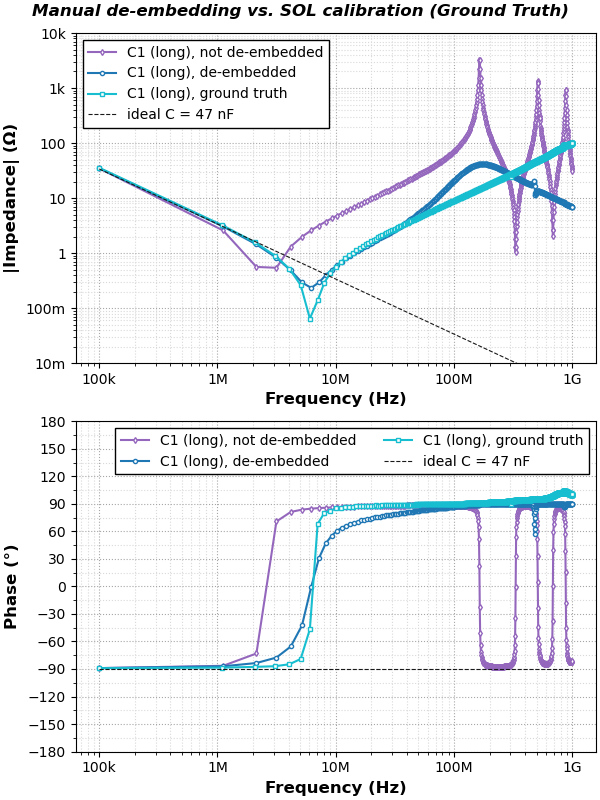

<AxesSubplot:xlabel='Frequency (Hz)', ylabel='Phase (°)'>

In [23]:
# Mise en place d'une nouvelle figure
fig3, axs3 = create_z_vs_f_double_figure("fig3-c1_long_impedance_comparison_deembedding_vs_sol_calibration_plot")
fig, axs = fig3, axs3  # simplifie les copier-coller

# Tracé de l'impédance de C1 avant de-embedding
f_values = frequences[MEAS_C1_LONG]
z_values = donnees_z[MEAS_C1_LONG]
add_z_vs_f_lineplot_two_panels(f_values, z_values,
                               axs=axs, key=MEAS_C1_LONG)

# Tracé de l'impédance de C1 après de-embedding manuel
f_values = frequences[DUT_C1_LONG]
z_values = donnees_z[DUT_C1_LONG]
add_z_vs_f_lineplot_two_panels(f_values, z_values,
                               axs=axs, key=DUT_C1_LONG)

# Tracé de l'impédance de C1 après calibration SOL (sans de-embedding manuel)
f_values = frequences[GT_C1_LONG]
z_values = donnees_z[GT_C1_LONG]
add_z_vs_f_lineplot_two_panels(f_values, z_values,
                               axs=axs, key=GT_C1_LONG)

# Ajout de l'impédance du condensateur idéal attendue
c_ideal = 47e-9  # in F
add_ideal_c_vs_f_lineplot_two_panels(f_values, c_ideal, axs=axs)

# Améliorations cosmétiques diverses
add_figure_title("Manual de-embedding vs. SOL calibration (Ground Truth)", fig=fig)
axs[0].set_ylim(0.01, 10e3)  # autrement perte d'espace en raison de la trace "ideal C"
update_panel_cosmeticks(legendncol=2, ax=axs[1])  # légende à 2 colonnes pour le graphe de phase

In [24]:
save_figure(fig=fig3, fmt="png")

## ???/ Mesures de dispositifs additionels

Pour le reste du TP, nous continuerons de travailler en utilisant la calibration SOL réalisée précédemment.

### ???-? Mesure d'un condensateur C2 similaire au C1 précédent mais de plus valeur différente

#### Mesure du S11 avec le condensateur C2

Effectuez le relevé expérimental du $S_{11}$ du condensateur C2 (dans sa version aux pattes longues).

#### Calcul des valeurs expérimentales (calibrées) de l'impédance de C2

Chargez le fichier `*.s1p` obtenu et calculez les valeurs d'impédance associées.

NB : la clef de dictionnaire associée est `GT_C2_LONG`.

In [25]:
filename = "<nom_du_fichier_de_donnees_s11_associe_a_gt_c2_long.s1p"  # À MODIFIER SELON LE NOM DE VOTRE FICHIER
filename = "prototype-gt_c2_long.s1p"  # DEBUG

# Chargement des données de mesures (fréquences et valeurs de S11) contenues dans le fichier `filename`.
frequences[GT_C2_LONG], donnees_s11[GT_C2_LONG] = load_nanovna_s1p_file(data_directory / filename)

# Calcul des valeurs d'impédance de C2 (aux pattes longues) à partir des celles de S11
donnees_z[GT_C2_LONG] = compute_shunt_impedance(donnees_s11[GT_C2_LONG])

#### ??-?.c/ Comparaison graphique des impédances de C1 et de C2 (pattes longues)

<IPython.core.display.Javascript object>


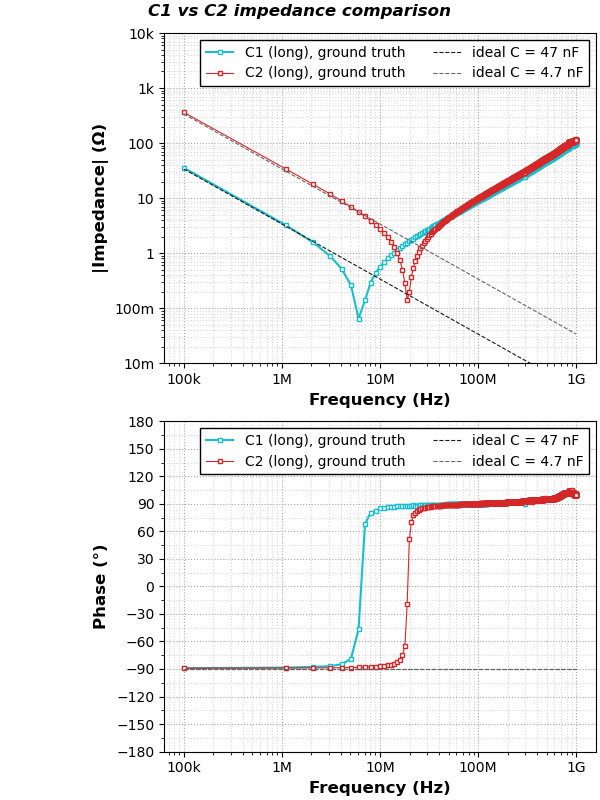

<AxesSubplot:xlabel='Frequency (Hz)', ylabel='Phase (°)'>

In [26]:
# Mise en place d'une nouvelle figure
fig4, axs4 = create_z_vs_f_double_figure("fig4-c1_long_vs_c2_long_comparison_plot")
fig, axs = fig4, axs4  # simplifie les copier-coller

# Tracé de l'impédance de C1 (ground truth)
f_values = frequences[GT_C1_LONG]
z_values = donnees_z[GT_C1_LONG]
add_z_vs_f_lineplot_two_panels(f_values, z_values,
                               axs=axs, key=GT_C1_LONG)

# Tracé de l'impédance de C2 (ground truth)
f_values = frequences[GT_C2_LONG]
z_values = donnees_z[GT_C2_LONG]
add_z_vs_f_lineplot_two_panels(f_values, z_values, color="tab:red",
                               axs=axs, key=GT_C2_LONG)

# Ajout de l'impédance attendue des condensateurs idéaux
for c_ideal in [47e-9, 4.7e-9]:  # in F
    add_ideal_c_vs_f_lineplot_two_panels(f_values, c_ideal, axs=axs)

# Améliorations cosmétiques diverses
add_figure_title("C1 vs C2 impedance comparison", fig=fig)
axs[0].set_ylim(0.01, 10e3)  # autrement perte d'espace en raison de la trace "ideal C"
update_panel_cosmeticks(legendncol=2, ax=axs[0])  # légende à 2 colonnes
update_panel_cosmeticks(legendncol=2, ax=axs[1])  # légende à 2 colonnes

In [27]:
save_figure(fig=fig4, fmt="png")

### ???-? Mesure d'un condensateur de même valeur que le C1 précédent mais aux pattes plus courtes

####  Mesure du S11 avec le condensateur C1 aux pattes raccourcies

Effectuez le relevé expérimental du $S_{11}$ du condensateur C1 dans sa version aux pattes (plus) courtes.

#### Calcul des valeurs expérimentales (calibrées) de l'impédance de C1 aux pattes raccourcies

Chargez le fichier `*.s1p` obtenu et calculez les valeurs d'impédance associées.

NB : la clef de dictionnaire associée est `GT_C1_SHORT`.

In [28]:
filename = "<nom_du_fichier_de_donnees_s11_associe_a_gt_c1_short.s1p"  # À MODIFIER SELON LE NOM DE VOTRE FICHIER
filename = "prototype-gt_c1_short.s1p"  # DEBUG

# Chargement des données de mesures (fréquences et valeurs de S11) contenues dans le fichier `filename`.
frequences[GT_C1_SHORT], donnees_s11[GT_C1_SHORT] = load_nanovna_s1p_file(data_directory / filename)

# Calcul des valeurs d'impédance de C1 (aux pattes courtes) à partir des celles de S11
donnees_z[GT_C1_SHORT] = compute_shunt_impedance(donnees_s11[GT_C1_SHORT])

#### ??-?.c/ Comparaison graphique des impédances de C1 (pattes longues) et de C1 (pattes courtes)

<IPython.core.display.Javascript object>


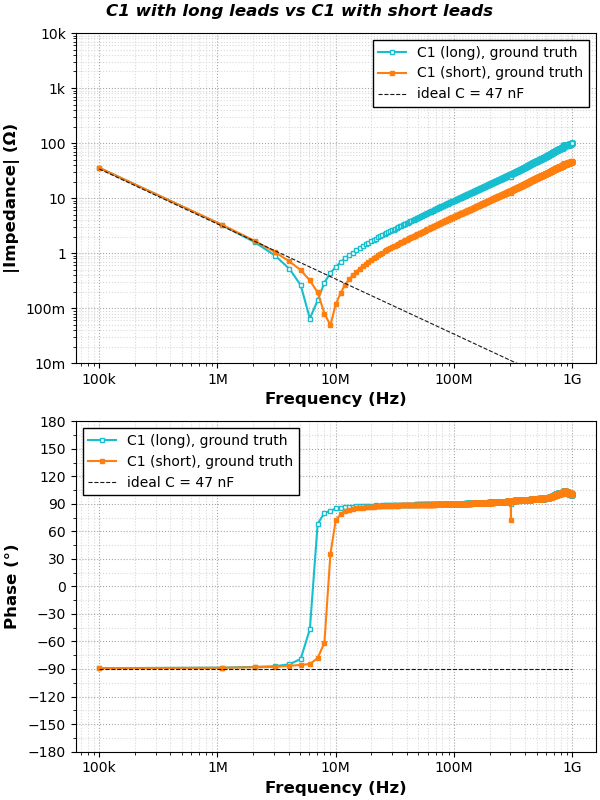

(0.01, 10000.0)

In [29]:
# Mise en place d'une nouvelle figure
fig5, axs5 = create_z_vs_f_double_figure("fig5-c1_long_vs_c1_short_comparison_plot")
fig, axs = fig5, axs5  # simplifie les copier-coller

# Tracé de l'impédance de C1 aux pattes longues (ground truth)
f_values = frequences[GT_C1_LONG]
z_values = donnees_z[GT_C1_LONG]
add_z_vs_f_lineplot_two_panels(f_values, z_values,
                               axs=axs, key=GT_C1_LONG)

# Tracé de l'impédance de C1 aux pattes longues (ground truth)
f_values = frequences[GT_C1_SHORT]
z_values = donnees_z[GT_C1_SHORT]
add_z_vs_f_lineplot_two_panels(f_values, z_values,
                               axs=axs, key=GT_C1_SHORT)

# Ajout de l'impédance attendue du condensateur idéal
c_ideal = 47e-9  # in F
add_ideal_c_vs_f_lineplot_two_panels(f_values, c_ideal, axs=axs)

# Améliorations cosmétiques diverses
add_figure_title("C1 with long leads vs C1 with short leads", fig=fig)
axs[0].set_ylim(0.01, 10e3)  # autrement perte d'espace en raison de la trace "ideal C"
#update_panel_cosmeticks(legendncol=2, ax=axs[0])  # légende à 2 colonnes (graphe du module)
#update_panel_cosmeticks(legendncol=2, ax=axs[1])  # légende à 2 colonnes (graphe de la phase)

In [30]:
save_figure(fig=fig5, fmt="png")

### ???-? Mesure de composants additionnels

Pour information, les clefs suivantes : `GT_C3`, `GT_C4`, `GT_R1`, `GT_R2`, `GT_L1`, `GT_L2` et `GT_P1`, ont été prédéfinies dans le fichier `impedance_measurement_stylesheet.py`. Chacune de ces clefs est associée à son propre style pour les graphes.

Si cela ne suffisait pas pour vos expériences, sachez qu'il est également possible de ne pas passer de clef lors de l'ajout d'une ligne de mesures à un graphe à l'aide de la fonction `add_z_vs_f_lineplot_two_panels` et d'indiquer explicitement le style de ligne désiré à la place. Vous trouverez ci-dessous un exemple détaillant certaines des propriétés graphiques les plus courantes (aucune n'est obligatoire) :
```python
add_z_vs_f_lineplot_two_panels(
    f_values, z_values,
    color="tab:blue",  # couleur bleue de la série Tableau10
                       # Les couleurs usuelles "red", "blue"...
                       # sont également possibles ainsi que
                       # "0.2", "0.7" pour des niveaux de gris
                       # (avec "0.0": noir et "1.0": blanc)
    linestyle="-",     # ou "solid", ou aussi "--"/"dashed",
                       # "-."/"dashdot", ":"/"dotted"
    linewidth=1.5,     # épaisseur de ligne de 1,5 point
    marker="s",        # marqueurs carrés. "" évite les marqueurs
    markersize=3,
    markerfacecolor="white",  # intérieur des marqueurs blanc 
    axs=axs)
```